In [ ]:
import numpy as np
import pandas as pd
import math
import requests
from bs4 import BeautifulSoup
import html5lib
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

ImportError: No module named 'requests'

In [2]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [3]:
team_map = {
    'GE' : 'Geelong',
    'SK' : 'St Kilda',
    'FR' : 'Fremantle',
    'CW' : 'Collingwood',
    'PA' : 'Port Adelaide',
    'GW' : 'Greater Western Sydney',
    'ES' : 'Essendon',
    'WC' : 'West Coast',
    'BL' : 'Brisbane Lions',
    'RI' : 'Richmond',
    'GC' : 'Gold Coast',
    'AD' : 'Adelaide',
    'HW' : 'Hawthorn',
    'WB' : 'Western Bulldogs',
    'CA' : 'Carlton',
    'SY' : 'Sydney',
    'ME' : 'Melbourne',
    'NM' : 'North Melbourne'
}
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Kangaroos' : 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}

In [4]:
def scrape_history(team, table_num, proxy):
    url = 'https://afltables.com/afl/teams/'+mapping[team]+'/allgames.html'
    r = requests.get(url, headers={'User-Agent':'test'},proxies=proxy)
    soup = BeautifulSoup(r.text, "html")
    table = soup.find_all('table')[table_num]
    data = []
    rows = table.find_all(['tr','th'])
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
    data = data[14:]
    df = pd.DataFrame(data[1:], columns = ['Rnd','T', 'Opponent', 'Scoring', 'F', 'Scoring', 'A', 'R', 'M', 'WDL', 'Venue', 'Crowd', 'Date'])
    df = df.drop(df.tail(2).index)
    return df[df['T'] != 'F']

In [19]:
teams = list(mapping.keys()) 
teams.remove('Kangaroos')
team_df = {}
for team in teams:
    for season in range(1,16):
        print(team,season)
        if (season < 8 or team != 'Greater Western Sydney') and (season < 9 or team != 'Gold Coast'):
            team_df[team,season] = scrape_history(team, season, proxyDict)

Richmond 1
Richmond 2
Richmond 3
Richmond 4
Richmond 5
Richmond 6
Richmond 7
Richmond 8
Richmond 9
Richmond 10
Richmond 11
Richmond 12
Richmond 13
Richmond 14
Richmond 15
West Coast 1
West Coast 2
West Coast 3
West Coast 4
West Coast 5
West Coast 6
West Coast 7
West Coast 8
West Coast 9
West Coast 10
West Coast 11
West Coast 12
West Coast 13
West Coast 14
West Coast 15
Sydney 1
Sydney 2
Sydney 3
Sydney 4
Sydney 5
Sydney 6
Sydney 7
Sydney 8
Sydney 9
Sydney 10
Sydney 11
Sydney 12
Sydney 13
Sydney 14
Sydney 15
Adelaide 1
Adelaide 2
Adelaide 3
Adelaide 4
Adelaide 5
Adelaide 6
Adelaide 7
Adelaide 8
Adelaide 9
Adelaide 10
Adelaide 11
Adelaide 12
Adelaide 13
Adelaide 14
Adelaide 15
Geelong 1
Geelong 2
Geelong 3
Geelong 4
Geelong 5
Geelong 6
Geelong 7
Geelong 8
Geelong 9
Geelong 10
Geelong 11
Geelong 12
Geelong 13
Geelong 14
Geelong 15
Greater Western Sydney 1
Greater Western Sydney 2
Greater Western Sydney 3
Greater Western Sydney 4
Greater Western Sydney 5
Greater Western Sydney 6
Greater We

In [159]:
def team5(team, proxy, season, shift=1, web=False):
    roll = 25
    if web is True:
        df = scrape_history(team, season, proxy)
    else:
        df = team_df[team, season]
    hist = pd.DataFrame()
    hist['Team'] = np.full(len(df),team,dtype=object)
    hist['Rnd'] = np.array([s.replace('R' , '') for s in df['Rnd']]).astype(int)
    hist['T'] = df['T']
    hist['Opponent'] = df['Opponent']
    result = np.where(df['R']=='W', 1, df['R'])
    result = np.where(result=='D', 1, result)
    hist['R'] = np.where(result=='L', 0, result)
       
    hist['F_mean'] = df['F'].shift(shift).rolling(roll,min_periods=1).mean()
    hist['A_mean'] = df['A'].shift(shift).rolling(roll,min_periods=1).mean()
    hist['M_mean'] = df['M'].shift(shift).rolling(roll,min_periods=1).mean()
    hist['W_sum'] = hist['R'].shift(shift).rolling(roll,min_periods=2).sum()
    hist['F_std'] = df['F'].shift(shift).rolling(roll,min_periods=1).std()
    hist['A_std'] = df['A'].shift(shift).rolling(roll,min_periods=1).std()
    hist['M_std'] = df['M'].shift(shift).rolling(roll,min_periods=1).std()
    hist['perc'] = hist['F_mean']/hist['A_mean']
    return hist

In [160]:
for season in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    year=str(2019-season)
    print(year)
    teams = list(mapping.keys()) 
    teams.remove('Kangaroos')
    
    if season >= 8:
        teams.remove('Greater Western Sydney') 
    if season >= 9:
        teams.remove('Gold Coast') 

    team_hg = []
    results = []
    for team in teams:        
        df = team5(team,proxyDict,season).iloc[2:].reset_index(drop=True)
        home_df = df[df['T'] == 'H'].reset_index(drop=True)
        results.append(home_df['R'])

        for i in range(len(home_df)):
            opponent = home_df['Opponent'][i]
            if opponent == 'Kangaroos':
                opponent = 'North Melbourne'
            print(team,opponent)
            opp_df = team5(opponent,proxyDict,season)
            rnd = home_df['Rnd'][i]
            home = home_df[home_df['Rnd'] ==
                           rnd][['Rnd','F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']].values
            away = opp_df[opp_df['Rnd'] == 
                          rnd][['F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']].values
            team_hg.append(np.concatenate([home,away],axis=1)[0])
    y = [y for x in results for y in x]
    np.save('training/results-'+year+'.npy', y)
    np.save('training/training-'+year+'.npy', team_hg)

2018
Richmond Hawthorn
Richmond Brisbane Lions
Richmond Fremantle
Richmond St Kilda
Richmond Sydney
Richmond Adelaide
Richmond Collingwood
Richmond Geelong
Richmond Essendon
Richmond Western Bulldogs
West Coast Geelong
West Coast Gold Coast
West Coast Port Adelaide
West Coast Richmond
West Coast St Kilda
West Coast Essendon
West Coast Greater Western Sydney
West Coast Western Bulldogs
West Coast Fremantle
West Coast Melbourne
Sydney Greater Western Sydney
Sydney Adelaide
Sydney North Melbourne
Sydney Fremantle
Sydney Carlton
Sydney West Coast
Sydney Geelong
Sydney Gold Coast
Sydney Collingwood
Sydney Hawthorn
Adelaide Collingwood
Adelaide Gold Coast
Adelaide Carlton
Adelaide Western Bulldogs
Adelaide Greater Western Sydney
Adelaide West Coast
Adelaide Geelong
Adelaide Melbourne
Adelaide Port Adelaide
Adelaide North Melbourne
Geelong St Kilda
Geelong Sydney
Geelong Greater Western Sydney
Geelong Carlton
Geelong North Melbourne
Geelong Richmond
Geelong Melbourne
Geelong Brisbane Lions
Ge

Carlton Hawthorn
2016
Richmond Adelaide
Richmond Port Adelaide
Richmond Hawthorn
Richmond Sydney
Richmond Gold Coast
Richmond Brisbane Lions
Richmond Essendon
Richmond Collingwood
Richmond Geelong
Richmond St Kilda
West Coast Fremantle
West Coast Richmond
West Coast Collingwood
West Coast St Kilda
West Coast Gold Coast
West Coast Adelaide
West Coast Essendon
West Coast North Melbourne
West Coast Melbourne
West Coast Hawthorn
Sydney Greater Western Sydney
Sydney West Coast
Sydney Essendon
Sydney North Melbourne
Sydney Melbourne
Sydney Western Bulldogs
Sydney Hawthorn
Sydney Carlton
Sydney Port Adelaide
Sydney Richmond
Adelaide Sydney
Adelaide Fremantle
Adelaide Geelong
Adelaide Greater Western Sydney
Adelaide St Kilda
Adelaide North Melbourne
Adelaide Collingwood
Adelaide Essendon
Adelaide Brisbane Lions
Adelaide West Coast
Geelong Brisbane Lions
Geelong Gold Coast
Geelong West Coast
Geelong Greater Western Sydney
Geelong North Melbourne
Geelong Sydney
Geelong Adelaide
Geelong Western B

Richmond Hawthorn
Richmond Melbourne
Richmond Fremantle
Richmond Sydney
Richmond Brisbane Lions
Richmond Port Adelaide
Richmond Greater Western Sydney
Richmond Essendon
Richmond St Kilda
West Coast St Kilda
West Coast Port Adelaide
West Coast Fremantle
West Coast Greater Western Sydney
West Coast North Melbourne
West Coast Gold Coast
West Coast Sydney
West Coast Richmond
West Coast Collingwood
West Coast Melbourne
Sydney North Melbourne
Sydney Fremantle
Sydney Hawthorn
Sydney Geelong
Sydney Port Adelaide
Sydney Greater Western Sydney
Sydney Carlton
Sydney Essendon
Sydney St Kilda
Sydney Richmond
Adelaide Sydney
Adelaide Greater Western Sydney
Adelaide Melbourne
Adelaide Collingwood
Adelaide Gold Coast
Adelaide North Melbourne
Adelaide Port Adelaide
Adelaide Hawthorn
Adelaide West Coast
Adelaide Richmond
Adelaide St Kilda
Geelong West Coast
Geelong Hawthorn
Geelong Richmond
Geelong North Melbourne
Geelong Carlton
Geelong St Kilda
Geelong Essendon
Geelong Western Bulldogs
Geelong Fremant

Richmond Gold Coast
Richmond North Melbourne
Richmond Western Bulldogs
Richmond Essendon
Richmond Port Adelaide
West Coast Hawthorn
West Coast North Melbourne
West Coast St Kilda
West Coast Fremantle
West Coast Carlton
West Coast Gold Coast
West Coast Sydney
West Coast Brisbane Lions
West Coast Geelong
West Coast Collingwood
Sydney North Melbourne
Sydney Adelaide
Sydney Melbourne
Sydney Western Bulldogs
Sydney Geelong
Sydney Greater Western Sydney
Sydney Brisbane Lions
Sydney St Kilda
Sydney Collingwood
Sydney Hawthorn
Adelaide Greater Western Sydney
Adelaide Port Adelaide
Adelaide Geelong
Adelaide Collingwood
Adelaide St Kilda
Adelaide Richmond
Adelaide West Coast
Adelaide Essendon
Adelaide Fremantle
Adelaide Gold Coast
Geelong Richmond
Geelong Melbourne
Geelong Greater Western Sydney
Geelong Port Adelaide
Geelong Collingwood
Geelong Essendon
Geelong Adelaide
Geelong St Kilda
Geelong Western Bulldogs
Geelong Sydney
Greater Western Sydney West Coast
Greater Western Sydney Western Bulld

Adelaide Melbourne
Adelaide Essendon
Adelaide Geelong
Adelaide Western Bulldogs
Adelaide St Kilda
Geelong Port Adelaide
Geelong Richmond
Geelong Sydney
Geelong Melbourne
Geelong North Melbourne
Geelong Hawthorn
Geelong Brisbane Lions
Geelong Collingwood
Geelong Carlton
Geelong West Coast
Melbourne Adelaide
Melbourne Brisbane Lions
Melbourne Western Bulldogs
Melbourne West Coast
Melbourne Port Adelaide
Melbourne Collingwood
Melbourne Essendon
Melbourne Sydney
Melbourne Richmond
Melbourne North Melbourne
Port Adelaide Brisbane Lions
Port Adelaide St Kilda
Port Adelaide Carlton
Port Adelaide Richmond
Port Adelaide Sydney
Port Adelaide Collingwood
Port Adelaide Adelaide
Port Adelaide Hawthorn
Port Adelaide West Coast
Port Adelaide Melbourne
Collingwood Hawthorn
Collingwood Essendon
Collingwood North Melbourne
Collingwood Geelong
Collingwood Western Bulldogs
Collingwood West Coast
Collingwood St Kilda
Collingwood Richmond
Collingwood Carlton
Collingwood Adelaide
Hawthorn North Melbourne
Haw

Essendon Adelaide
Essendon St Kilda
Western Bulldogs St Kilda
Western Bulldogs Richmond
Western Bulldogs West Coast
Western Bulldogs North Melbourne
Western Bulldogs Brisbane Lions
Western Bulldogs Port Adelaide
Western Bulldogs Melbourne
Western Bulldogs Carlton
Western Bulldogs Sydney
Western Bulldogs Essendon
St Kilda Geelong
St Kilda Essendon
St Kilda Collingwood
St Kilda Melbourne
St Kilda Western Bulldogs
St Kilda Fremantle
St Kilda Hawthorn
St Kilda Port Adelaide
St Kilda Adelaide
North Melbourne Hawthorn
North Melbourne Melbourne
North Melbourne Sydney
North Melbourne West Coast
North Melbourne Geelong
North Melbourne St Kilda
North Melbourne Collingwood
North Melbourne Brisbane Lions
North Melbourne Western Bulldogs
North Melbourne Port Adelaide
Fremantle Richmond
Fremantle Geelong
Fremantle Western Bulldogs
Fremantle Port Adelaide
Fremantle North Melbourne
Fremantle Essendon
Fremantle Melbourne
Fremantle West Coast
Fremantle St Kilda
Fremantle Collingwood
Brisbane Lions Sydne

Carlton Fremantle
Carlton Melbourne
Carlton Richmond
2005
Richmond Fremantle
Richmond Port Adelaide
Richmond Carlton
Richmond West Coast
Richmond Adelaide
Richmond Sydney
Richmond Essendon
Richmond St Kilda
Richmond Western Bulldogs
Richmond Hawthorn
West Coast Western Bulldogs
West Coast Sydney
West Coast St Kilda
West Coast Port Adelaide
West Coast Essendon
West Coast Carlton
West Coast Brisbane Lions
West Coast Hawthorn
West Coast Fremantle
West Coast Adelaide
Sydney Adelaide
Sydney Melbourne
Sydney Essendon
Sydney Port Adelaide
Sydney Fremantle
Sydney Collingwood
Sydney Geelong
Sydney West Coast
Sydney Brisbane Lions
Sydney North Melbourne
Adelaide Port Adelaide
Adelaide North Melbourne
Adelaide Brisbane Lions
Adelaide Carlton
Adelaide Essendon
Adelaide Fremantle
Adelaide Western Bulldogs
Adelaide Sydney
Adelaide Melbourne
Adelaide Collingwood
Geelong Essendon
Geelong Western Bulldogs
Geelong St Kilda
Geelong North Melbourne
Geelong Fremantle
Geelong Adelaide
Geelong Hawthorn
Geelo

In [161]:
# team5('Hawthorn',proxyDict,1)

In [318]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

X1 = np.load('training/training-2018.npy')
X2 = np.load('training/training-2017.npy')
X3 = np.load('training/training-2016.npy')
X4 = np.load('training/training-2015.npy')
X5 = np.load('training/training-2014.npy')
X6 = np.load('training/training-2013.npy')
X7 = np.load('training/training-2012.npy')
X8 = np.load('training/training-2011.npy')
X9 = np.load('training/training-2010.npy')
X10 = np.load('training/training-2009.npy')
X11 = np.load('training/training-2008.npy')
X12 = np.load('training/training-2007.npy')
X13 = np.load('training/training-2006.npy')
X14 = np.load('training/training-2005.npy')
X15 = np.load('training/training-2004.npy')
mask = np.isnan(X8).any(axis=1)
index = np.where(mask==True)[0][0] ## X8 has a row containing nulls
X8 = np.delete(X8, index, 0)

X = np.concatenate([
    X1,
    X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15], axis=0)

y1 = np.load('training/results-2018.npy')
y2 = np.load('training/results-2017.npy')
y3 = np.load('training/results-2016.npy')
y4 = np.load('training/results-2015.npy')
y5 = np.load('training/results-2014.npy')
y6 = np.load('training/results-2013.npy')
y7 = np.load('training/results-2012.npy')
y8 = np.load('training/results-2011.npy')
y9 = np.load('training/results-2010.npy')
y10 = np.load('training/results-2009.npy')
y11 = np.load('training/results-2008.npy')
y12 = np.load('training/results-2007.npy')
y13 = np.load('training/results-2006.npy')
y14 = np.load('training/results-2005.npy')
y15 = np.load('training/results-2004.npy')
y8 = np.delete(y8, index)

y = np.concatenate([
    y1,
    y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15], axis=0)

print(X.shape)
print(y.shape)

print('Wins vs losses',np.sum(y)/float(len(y)))

training_cols = ['Rnd','h_F_mean','h_F_std','h_A_mean','h_A_std','h_M_mean','h_M_std','h_W_sum','h_perc',
                       'a_F_mean','a_F_std','a_A_mean','a_A_std','a_M_mean','a_M_std','a_W_sum','a_perc',
                'ha_F_mean','ha_F_std','ha_A_mean','ha_A_std','ha_M_mean','ha_M_std','ha_perc']
#                 'h_F_CV','h_A_CV','h_M_CV','a_F_CV','a_A_CV','a_M_CV']

def div_cols(X):
    df = pd.DataFrame(X)
    for i in [1,2,3,4,5,6,8]:
        df[16+i] = df[i]/df[i+8].astype(float)
    df = df.replace([np.inf, -np.inf], 0)
    df.columns = training_cols
    return df.values

(2548, 17)
(2548,)
Wins vs losses 0.57574568288854


In [363]:
classifier = XGBClassifier(base_score=0.57574568288854)

# Utility function to report best scores
def report(results, n_top=1):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

In [388]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
# specify parameters and distributions to sample from
param_dist = {"N_estimators": [200,250,300,350,400,450,500,550,600],
              "max_depth": [3, 4],
              "learning_rate": [0.1,0.03,0.05,0.08,0.01,0.005,0.001],
              "colsample_bytree": [0.6,0.8,1],
              "subsample": [0.6,0.8,1],
              "reg_lambda": [0.1,0.5,1],
              "reg_alpha": [0.1,0.5,1]
}
def afl_loss(y_true,y_pred): 
    return np.sum(1+np.log2(y_true*y_pred + (1-y_true)*(1-y_pred)))

scorer = make_scorer(afl_loss, greater_is_better=True, needs_proba=True)

# run randomized search
n_iter_search = 500
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist,
                                   scoring=scorer,
                                   n_jobs=-1,
                                   n_iter=n_iter_search, cv=5, iid=False)

In [396]:
from sklearn.model_selection import train_test_split
from time import time
X_list = [X1,X2,X3,X4,X5,X6,X7,X8,X9]#,X10,X11,X12,X13,X14,X15]
y_list = [y1,y2,y3,y4,y5,y6,y7,y8,y9]#,y10,y11,y12,y13,y14,y15]
scores = []
best_models = []

for j in range(len(X_list)):
    y = y_list.copy()
    X = X_list.copy()
    y_test = y.pop(j)
    X_test = X.pop(j)
    y_train = np.concatenate(y, axis=0)
    X_train = np.concatenate(X, axis=0)

    X_train = div_cols(X_train)
    X_test = div_cols(X_test)

    start = time()
    random_search.fit(X_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), n_iter_search))
    report(random_search.cv_results_)
    model = random_search.best_estimator_ 
        
    y_true = y_test.copy()
    y_pred = model.predict_proba(X_test)[:,1]
    score = afl_loss(y_true,y_pred)
    scores.append(score)
    best_models.append(model)
    print("Season score",2019-j-1,":",score,'Accuracy:',model.score(X_test,y_test))
    print("")
print('Mean scores',np.mean(scores))

RandomizedSearchCV took 125.74 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 42.890 (std: 7.090)
Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 1, 'N_estimators': 200}
Season score 2018 : 29.313111040663827 Accuracy: 0.7

RandomizedSearchCV took 127.42 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 45.902 (std: 5.692)
Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 1, 'N_estimators': 450}
Season score 2017 : 11.041855868252439 Accuracy: 0.6333333333333333

RandomizedSearchCV took 127.83 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 40.603 (std: 6.932)
Parameters: {'subsample': 1, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.8, 'N_estimators': 500}
Model with

In [447]:
def averagingImp(models=[]):
    predictions = np.column_stack([
        model.feature_importances_ for model in models
    ])
    return np.mean(predictions, axis=1)

imp = pd.DataFrame(data=averagingImp(best_models),
             index=training_cols, 
             columns=['importance']).sort_values(by=['importance'], ascending=False)
imp

,importance
ha_perc,0.208738
ha_F_mean,0.084453
ha_A_mean,0.057202
h_perc,0.047855
ha_M_mean,0.046965
h_M_mean,0.040779
h_W_sum,0.040066
a_M_mean,0.039654
h_F_mean,0.035426
a_A_mean,0.035299


In [444]:
def averagingModels(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return np.mean(predictions, axis=1)

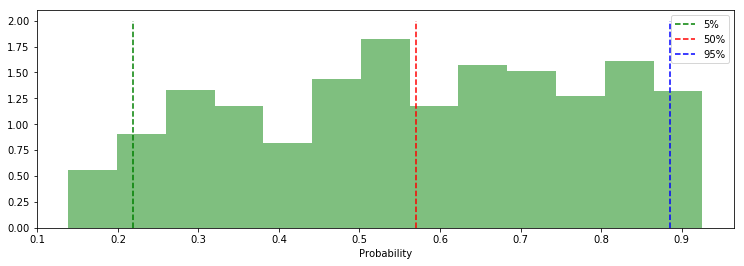

In [445]:
plt.figure(figsize=(12.5,4))
line_height = 2
data = averagingModels(X_train,best_models)
x = plt.hist(data, bins='auto', density=True, facecolor='green', alpha=0.5)

plt.vlines(np.percentile(data, 5), 0, line_height, linestyle="--", colors='green', label="5%")
plt.vlines(np.percentile(data, 50), 0, line_height, linestyle="--", colors='red', label="50%")
plt.vlines(np.percentile(data, 95), 0, line_height, linestyle="--", colors='blue', label="95%")
plt.xlabel('Probability')
plt.legend()

## Scoring

In [432]:
games = [
    ['Sydney', 'Essendon', 'S.C.G.'],
    ['Western Bulldogs', 'Brisbane Lions', 'Eureka Stadium'],
    ['Carlton', 'Collingwood', 'M.C.G.'],
    ['Gold Coast', 'Melbourne', 'Carrara'], 
    ['St Kilda', 'West Coast', 'Docklands'], 
    ['Port Adelaide', 'Adelaide', 'Adelaide Oval'],
    ['North Melbourne', 'Geelong', 'Docklands'], 
    ['Hawthorn', 'Greater Western Sydney', 'M.C.G.'],
    ['Fremantle', 'Richmond', 'Perth Stadium'] 
]

In [ ]:
scoring = []
for i in games:
    home = i[0]
    away = i[1]
    home_df = team5(home, proxyDict, season=0,shift=0,web=True).iloc[2:].tail(1)[
        ['Rnd','F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']]
    home_df['Rnd'] = home_df['Rnd'] + 1
    away_df = team5(away, proxyDict, season=0,shift=0,web=True).iloc[2:].tail(1)[
        ['F_mean','F_std','A_mean','A_std','M_mean','A_std','W_sum','perc']]
    scoring.append(np.concatenate([home_df.values[0],away_df.values[0]], axis=0))
scoring_enr = div_cols(scoring)

In [443]:
arr = np.c_[ games, averagingModels(scoring_enr,best_models) ] 
pd.DataFrame(arr,columns=['home','away','grnd','prob_home_win'])

,home,away,grnd,prob_home_win
0,Sydney,Essendon,S.C.G.,0.42351535
1,Western Bulldogs,Brisbane Lions,Eureka Stadium,0.55470246
2,Carlton,Collingwood,M.C.G.,0.302441
3,Gold Coast,Melbourne,Carrara,0.61423224
4,St Kilda,West Coast,Docklands,0.6797876
5,Port Adelaide,Adelaide,Adelaide Oval,0.5831062
6,North Melbourne,Geelong,Docklands,0.31667262
7,Hawthorn,Greater Western Sydney,M.C.G.,0.5443009
8,Fremantle,Richmond,Perth Stadium,0.7284038


In [ ]:
# pd.DataFrame(scoring_enr,columns=training_cols)

## Save models

In [440]:
# from joblib import dump, load
# for i in range(len(best_models)):
#     dump(best_models[i], 'models/model'+str(i)+'.joblib') 

## Load models

In [442]:
best_models = []
for i in range(9):
    best_models.append(load('models/model'+str(i)+'.joblib'))